In [1]:
from PIL.ExifTags import TAGS
import pathlib
import csv
import glob
from PIL import Image
import pandas as pd
import os
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
from skimage.color import rgb2gray
import os
import re
import math
import matplotlib.ticker as tck
import argparse
import cv2
import skimage as ski


c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Reading paths, removing copies (segc), removing contour

In [2]:
# recursive search for all tiff files
path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
files = glob.glob(path+ "/**/*.tiff", recursive=True)

print(len(files))

for path_file in files:
    if 'segc' in path_file or 'contour' in path_file:
        os.remove(path_file)
        
filtered_files = glob.glob(path+ "/**/*.tiff", recursive=True)
print(len(filtered_files))


1308
654


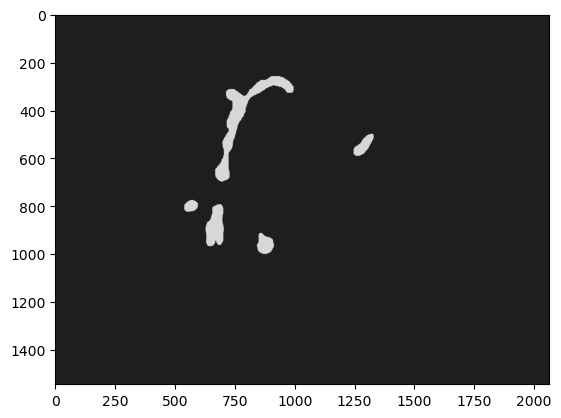

In [5]:
path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
paths = glob.glob(path+ "/**/*.tiff", recursive=True)
image = cv2.imread(paths[1]) ## read the first image from the list
plt.imshow(image)

Mapping info

In [6]:
concentration_mapping = {
'2mgml': '1',
'3mM': '2',
'40mM': '3'
}
material_mapping = {
'2mgml': '1',
'3mM': '2',
'40mM': '3'
}
reverse_material_mapping = {
'2mgml':'collagen 2mg/ml',
'3mM':'IPN 2.5mM',
'40mM':'IPN 40mM'
}
cell_mapping = {
'MCF10A': '1',
'MCF10A.DCIS.COM': '2',
'MCF10AT': '3'
}

IMAGE PROCESSING

No contours not found in image: C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis\230719_2mgml_2500cellsml_squarewells\MCF10A\2mgml\168h\10x_13_seg.tiff
No contours not found in image: C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis\230719_2mgml_2500cellsml_squarewells\MCF10A\2mgml\48h\10x_11_seg.tiff
No contours not found in image: C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis\230719_2mgml_2500cellsml_squarewells\MCF10A.DCIS.COM\2mgml\168h\10x_14_seg.tiff
No contours not found in image: C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis\230719_2mgml_2500cellsml_squarewells\MCF10A.DCIS.COM\2mgml\72h\20x_12_seg.tiff
No contours not found in image: C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\240h\10x_2_seg.tiff


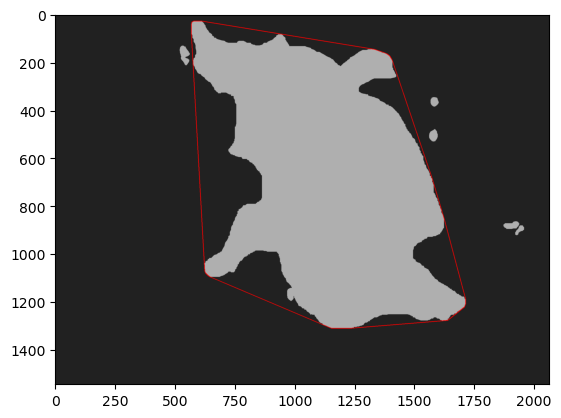

In [7]:
appended = []

first_image_displayed= False
first_convexhull_image_displayed = False
start= 0
for imagepath in paths: 
    firstimg = cv2.imread(imagepath) #load the image for each path
    secondimg = cv2.cvtColor(firstimg, cv2.COLOR_BGR2GRAY) # changing from BGR order to RGB
    #cv2.imwrite(imagepath, secondimg) #saves the new image over the original
    _, binary_image = cv2.threshold(secondimg, 128, 255, cv2.THRESH_BINARY) #applying binary thershold
    
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours in binary image

    color_image = cv2.cvtColor(secondimg.copy(), cv2.COLOR_GRAY2BGR) #copy but colorful for contour drawing
    cv2.drawContours(color_image, contours, -1, (0, 255, 0), 5) #drawing contours
    cv2.imwrite(imagepath +'_contour.tiff', color_image) #saving the contours

    if not first_image_displayed: #show first image
        plt.imshow(color_image)
        first_image_displayed = True
        
    contours_info=[]
    path1= imagepath.replace("/","\\")
    splitted = path1.split('\\')[-1]
    #print(imagepath)
    id = int(splitted.split('_')[-2])     
    magnification = int(splitted.split('_')[-3].rstrip('x'))    
    pixels = magnification//10
    incubation_time= int(path1.split('\\')[-2].rstrip('h'))   
    cell_line_name= path1.split('\\')[-4]          
    concentration= path1.split('\\')[-3]      
    experiment =path1.split('\\')[-5]
    wells = experiment.split('_')[-1]
    seeding = experiment.split('_')[-2].rstrip('cellsml')
    date = experiment.split('_')[-4]

    if contours:
        start1= 0
        for count, contour in enumerate(contours):
            area = cv2.contourArea(contour)/(pixels**2)                     
            perimeter = cv2.arcLength(contour, closed=True)/pixels #perimeter for each contour
            compactness = 4 * math.pi * area  / (perimeter**2) #compactness (spheroid area/area of object with the identical perimeter)
            rect = cv2.minAreaRect(contour) #minimal rectangle
            
            width, height = rect[1] #extracting the tuple containing rectangular dimensions
            aspect_ratio = width / height

            convexhull = cv2.convexHull(contour)
            convexhull_perimeter = cv2.arcLength(convexhull, closed=True)/pixels #perimeter for each contour
            convexhull_area = cv2.contourArea(convexhull)/(pixels**2)  
            convexity_perimeter = convexhull_perimeter/perimeter
            convexity_area = convexhull_area/area

            info={}
            info = {
                "id": start+1,
                "id_in_image": start1+1,
                "path": path1,
                "well_type": wells,
                "seeding_density": seeding,
                "date": date,
                "cell_line":cell_line_name,
                "cell_line_no": int(cell_mapping.get(cell_line_name)),
                "incubation_time": incubation_time,
                "image_id": id,
                "magnification": magnification,
                "material": (reverse_material_mapping.get(concentration)),
                "concentration": int(concentration_mapping.get(concentration)),
                "area": area,
                "perimeter": perimeter,
                "convex hull area": convexhull_area,
                "convex hull perimeter": convexhull_perimeter,
                "convexity_perimeter": convexity_perimeter,
                "convexity_area": convexity_area,
                "compactness": compactness,
                "aspect_ratio": aspect_ratio
                }
            contours_info.append(pd.DataFrame([info]) )  #appending the info to the contours_info
            start+= 1 
            start1  += 1
        appended.append(pd.concat(contours_info, ignore_index=True))  # Concatenate contours' df and append to 'appended'
    else: print("No contours not found in image:", imagepath)   

    if not first_convexhull_image_displayed: #show first convex image
        color_image = cv2.cvtColor(secondimg.copy(), cv2.COLOR_GRAY2BGR) #copy but colorful for contour drawing
        cv2.drawContours(color_image, [convexhull], -1, (255, 0, 0), 2) #drawing convexHull
        plt.imshow(color_image)


        first_image_displayed = True 

final_contours_info_1= pd.concat(appended, ignore_index=True)


In [8]:
print(final_contours_info_1)

        id  id_in_image                                               path  \
0        1            1  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
1        2            2  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
2        3            3  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
3        4            4  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
4        5            5  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
...    ...          ...                                                ...   
4769  4770            2  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
4770  4771            3  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
4771  4772            4  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
4772  4773            5  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   
4773  4774            6  C:\Users\srboval1\Time_Series_Instru\TimeSerie...   

        well_type seeding_density    date cell_line  cell_line_

DATA pre-PROCESSING

Filtering only files with contours

In [9]:
if final_contours_info_1.columns[0] == 'Unnamed: 0':
    final_contours_info = final_contours_info_1.drop(columns=['Unnamed: 0'])

final_contours_info_1.dropna(subset=['area'], inplace=True)


Normalizing numerical variables

In [11]:
norm = Normalizer() # Initialize the Normalizer
columns_to_normalize = ['area','perimeter', 'convexity_area', 'convexity_perimeter', 'aspect_ratio','convex hull area', 'compactness'] # selected variables to normalize
normalized = norm.fit_transform(final_contours_info_1[columns_to_normalize]) #normalizing
df_normalized = pd.DataFrame(normalized, columns=[col + '_N' for col in columns_to_normalize]) # df also with new columns
final_contours_info_with_normalized = pd.concat([final_contours_info_1, df_normalized], axis=1)


In [14]:
saving_path= 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles'
final_contours_info_with_normalized.to_csv(saving_path+'/contours_exp1.csv')  
